In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib
from time import time
from xml.etree import ElementTree as ET
import os
import pandas as pd
import sys
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from scipy import signal
from scipy.ndimage import zoom
import smtplib
from email.mime.text import MIMEText
import re
import skimage
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

from bigbrain.brain import bleaching_correction
from bigbrain.brain import z_score_brain
from bigbrain.brain import get_resolution
from bigbrain.brain import save_brain
from bigbrain.fictrac import load_fictrac
from bigbrain.fictrac import prep_fictrac
from bigbrain.utils import load_timestamps
from bigbrain.utils import sort_nicely
from bigbrain.utils import send_email
from bigbrain.glm import fit_glm
from bigbrain.glm import save_glm_map
from bigbrain.motcorr import get_motcorr_brain
from bigbrain.brain import load_numpy_brain
from bigbrain.utils import timing
from bigbrain.utils import sort_nicely

sys.path.insert(0, '/home/users/brezovec/projects/lysis/')
from bruker import *

sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

#%matplotlib inline
#%matplotlib notebook

In [35]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'

fly_folders = sorted(os.listdir(root_path))
fly_folders = [x for x in fly_folders if 'fly' in x]
sort_nicely(fly_folders)
print(fly_folders)

['fly_1', 'fly_2', 'fly_3', 'fly_4', 'fly_5', 'fly_6', 'fly_7', 'fly_8', 'fly_9', 'fly_10', 'fly_11', 'fly_12', 'fly_13', 'fly_14', 'fly_15', 'fly_16', 'fly_17', 'fly_18', 'fly_19', 'fly_20', 'fly_21', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']


In [36]:
desired_flies = [15,17,19,22,23,24,25,26] # 1 index
fly_folders = [fly_folders[i-1] for i in desired_flies]
print(fly_folders)

['fly_15', 'fly_17', 'fly_19', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']


### Load good anatomys

In [24]:
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central/20190318_meanbrain/affine2'

In [25]:
files = sorted(os.listdir(root_path))

In [26]:
brain_files = [x for x in files if 'affine' in x]

In [27]:
sort_nicely(brain_files)

In [28]:
brain_files

['affine_0.nii',
 'affine_1.nii',
 'affine_2.nii',
 'affine_3.nii',
 'affine_4.nii',
 'affine_5.nii',
 'affine_6.nii',
 'affine_7.nii']

In [26]:
#desired_brains = [1,2,3,13,14,15,16,17,18,19]
desired_brains = [17,25]
brain_files = [brain_files[i] for i in desired_brains]

IndexError: list index out of range

In [ ]:
brain_files

### 20190318 Remaking meanbrain

In [37]:
anatomy_files = []
for brain_file in fly_folders:
    anatomy_files.append(os.path.join(root_path, brain_file, 'anatomy.nii'))

In [38]:
anatomy_files

['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_15/anatomy.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_17/anatomy.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/anatomy.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_22/anatomy.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_23/anatomy.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_24/anatomy.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/anatomy.nii',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_26/anatomy.nii']

In [39]:
brains = []
for brain_file in anatomy_files:
    full_file = os.path.join(root_path, brain_file)
    brains.append(load_numpy_brain(full_file))

In [ ]:
anatomy_xml_files = []
for folder in fly_folders:
    anatomy_xml_files.append(os.path.join(root_path, folder, 'anatomy.xml'))

brain_ants = []
for i in range(len(brains)):
    print(i)
    ants_brain = ants.from_numpy(brains[i])
    ants_brain.set_spacing(get_resolution(anatomy_xml_files[i]))
    ants_brain = ants.n4_bias_field_correction(ants_brain)
    brain_ants.append(ants_brain)

0
1
2
3
4
5
6
7


In [ ]:
main_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central/20190318_meanbrain/n4'
for i in range(8):
    file = os.path.join(main_path, 'n4_' + str(i) + '.nii')
    save_brain(file, brain_ants[i].numpy())

In [4]:
main_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central/20190318_meanbrain/n4'
brains = []
for i in range(8):
    file = os.path.join(main_path, 'n4_' + str(i) + '.nii')
    brains.append(load_numpy_brain(file))

In [6]:
# rotate brains
for i in range(len(brains)):
    brains[i] = np.swapaxes(brains[i],0,1)

In [10]:
ants_brains = []
for i in range(8):
    ants_brains.append(ants.from_numpy(brains[i]))

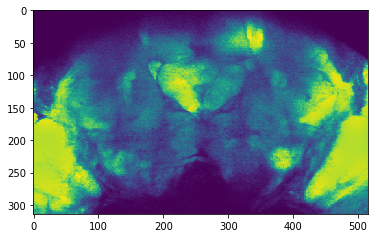

In [26]:
plt.imshow(ants_brains[0].numpy()[:,:,100])
plt.show()

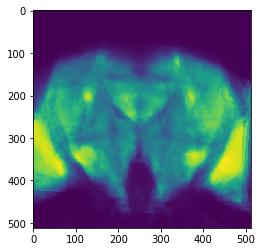

In [28]:
plt.imshow(master.numpy()[:,:,100])
plt.show()

In [23]:
master = ants.from_numpy(meanbrain)

In [ ]:
SyN_warps = []
for i in range(len(ants_brains)):
    print(i)
    t0 = time()
    slave = ants_brains[i]
    slave2master = ants.registration(master,
                                     slave,
                                     type_of_transform='SyN')
    SyN_warps.append(slave2master)
    print(time() - t0)

0
414.74372839927673
1
430.10302686691284
2
453.83417892456055
3
437.49090099334717
4
413.22401881217957
5
431.39634680747986
6
426.8981704711914
7


In [ ]:
folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central/20190318_meanbrain/syn'
for i in range(8):
    save_file = os.path.join(folder, 'syn_' + str(i) + '.nii')
    save_brain(save_file, SyN_warps[i].numpy())

In [ ]:
numpy_brains = []
for i in range(8):
    numpy_brains.append(SyN_warps[i]['warpedmovout'].numpy())

In [ ]:
meanbrain_array = np.asarray(numpy_brains)

In [19]:
meanbrain_array.shape

(8, 512, 512, 251)

In [ ]:
meanbrain = np.mean(meanbrain_array, axis=0)

In [ ]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central/20190318_meanbrain/syn/mean3.nii'
save_brain(file, meanbrain)

In [22]:
folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central/20190318_meanbrain/affine3'
for i in range(8):
    save_file = os.path.join(folder, 'affine_' + str(i) + '.nii')
    save_brain(save_file, numpy_brains[i])

In [32]:
# rotate brains
for i in range(len(brains)):
    brains[i] = np.swapaxes(brains[i],0,1)

In [10]:
master_ants = ants.from_numpy(brains[1])
master_ants.set_spacing((0.768, 0.768, 1))
slave_ants = ants.from_numpy(brains[0])
slave_ants.set_spacing((0.768, 0.768, 1))

In [11]:
slave_ants

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (300, 513, 211)
	 Spacing    : (0.768, 0.768, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [ ]:
t0 = time()
slave2master = ants.registration(master_n4, slave_n4, type_of_transform='SyNCC')
print(time() - t0)

In [20]:
t0 = time()
slave2master = ants.registration(master_n4,
                                 slave_n4,
                                 type_of_transform='SyN',
                                 grad_step=0.2,
                                 reg_iterations=(80,40,0),
                                 syn_sampling=16)
print(time() - t0)

710.7567551136017


In [21]:
save_file = os.path.join('/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/', '20190224_anatomy_central', '20190318_meanbrain', 'slave2master_iter_80.40.0_synsampling16.nii')
save_brain(save_file, slave2master['warpedmovout'].numpy())

##### Try bias correction

In [12]:
t0 = time()
master_n4 = ants.n4_bias_field_correction(master_ants)
print(time() - t0)

209.25340676307678


In [13]:
t0 = time()
slave_n4 = ants.n4_bias_field_correction(slave_ants)
print(time() - t0)

159.52121686935425


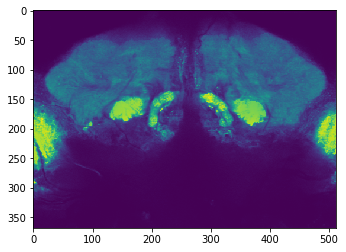

In [57]:
plt.imshow(master_n4.numpy()[:,:,80])
plt.show()

In [22]:
3

3

### Have outputed aligned brains below, picked best in image j, now averaging those:

In [14]:
brains_to_average = np.asarray(brains)

In [15]:
brains_to_average.shape

(6, 368, 512, 251)

In [16]:
meanbrain = np.mean(brains_to_average, axis=0)

In [17]:
meanbrain.shape

(368, 512, 251)

In [18]:
folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central/meanbrain1'

In [19]:
save_file = os.path.join(folder, 'meanbrain2.nii')
#brain_to_save = np.swapaxes(warps[i]['warpedmovout'].numpy(), 0, 1)
ants.image_write(ants.from_numpy(meanbrain), save_file)

### Meanbrain1 looks good! Lets re-align favorite brains to this meanbrain to make meanbrain2

### Reloaded brains above.

In [33]:
master_ants = ants.from_numpy(meanbrain)

In [61]:
meanbrain.shape

(512, 368, 251)

In [67]:
brains[3].shape

(508, 260, 291)

In [ ]:
warps = []
for i in range(len(brains)):
    t0 = time()
    slave_ants = ants.from_numpy(brains[i])
    warps.append(ants.registration(master_ants, slave_ants, type_of_transform='SyN'))
    print(time()-t0)

279.5783443450928
285.73746824264526
301.88328433036804
291.6295750141144
289.9910697937012
287.0485701560974


In [ ]:
folder = '20190313_aligned'
pre_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central'
directory = os.path.join(pre_directory, folder)
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
for i in range(len(warps)):
    save_file = os.path.join(directory, 'aligned_' + str(i) + '.nii')
    brain_to_save = np.swapaxes(warps[i]['warpedmovout'].numpy(), 0, 1)
    ants.image_write(ants.from_numpy(brain_to_save), save_file)

### Now averaging these to make meanbrain2

### I want to quickly align an optic lobe anatomy to it's map

In [37]:
anat_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_18/anatomy.nii'
glm_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_18/glm/multivariate_analysis_green.nii'
func_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_18/motcorr/motcorr_green.nii'

In [38]:
anat = ants.from_numpy(load_numpy_brain(anat_file))
glm_map = ants.from_numpy(load_numpy_brain(glm_file))
func = load_numpy_brain(func_file)

In [39]:
mean_func = ants.from_numpy(np.mean(func, axis=-1))

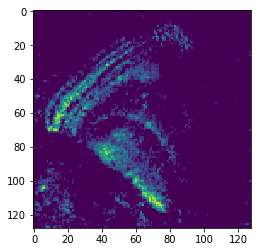

In [49]:
plt.imshow(glm_map.numpy()[:,:,20])
plt.show()

In [50]:
out = ants.registration(anat, mean_func, type_of_transform='Affine')

In [55]:
out

{'fwdtransforms': ['/tmp/tmpjpu_v02y0GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpjpu_v02y0GenericAffine.mat'],
 'warpedfixout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128, 45)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedmovout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (256, 256, 151)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]}

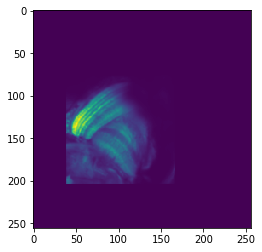

In [60]:
plt.imshow(out['warpedmovout'].numpy()[:,:,80])
plt.show()

In [41]:
transformlist = out['fwdtransforms']
out2 = ants.apply_transforms(anat,glm_map,transformlist).numpy()

In [44]:
out

{'fwdtransforms': ['/tmp/tmpdod7m0gh0GenericAffine.mat'],
 'invtransforms': ['/tmp/tmpdod7m0gh0GenericAffine.mat'],
 'warpedfixout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128, 45)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 'warpedmovout': ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (256, 256, 151)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]}

In [42]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_18/warped_glm.nii'
brain_to_save = np.swapaxes(out2['warpedmovout'].numpy(), 0, 1)
ants.image_write(ants.from_numpy(brain_to_save), save_file)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

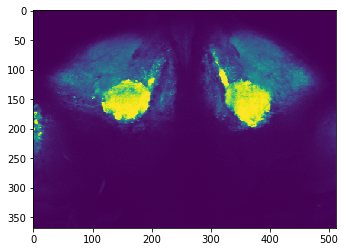

In [53]:
plt.imshow(master[:,:,65])
plt.show()

##### Lets align the 2nd best brain to this best brain

In [36]:
master = np.copy(brains[8])

In [37]:
del brains[8]

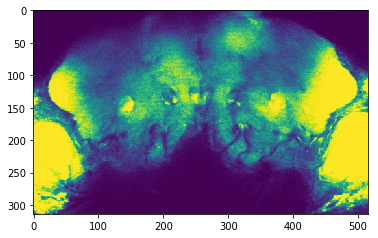

In [46]:
plt.imshow(brains[0][:,:,65])
plt.show()

In [47]:
master_ants = ants.from_numpy(master)

In [63]:
warps = []
for i in range(len(brains)):
    t0 = time()
    slave_ants = ants.from_numpy(brains[i])
    warps.append(ants.registration(master_ants, slave_ants, type_of_transform='SyN'))
    print(time()-t0)

276.7973232269287
282.71715784072876
313.03041911125183
313.6029562950134
302.22862792015076
295.8530032634735
310.35034370422363
311.43645310401917
314.143630027771


In [64]:
folder = '20190228_aligned'
pre_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190224_anatomy_central'
directory = os.path.join(pre_directory, folder)
if not os.path.exists(directory):
    os.makedirs(directory)

In [65]:
for i in range(len(warps)):
    save_file = os.path.join(directory, 'aligned_' + str(i) + '.nii')
    brain_to_save = np.swapaxes(warps[i]['warpedmovout'].numpy(), 0, 1)
    ants.image_write(ants.from_numpy(brain_to_save), save_file)

In [50]:
warped_numpy = warped['warpedmovout'].numpy()

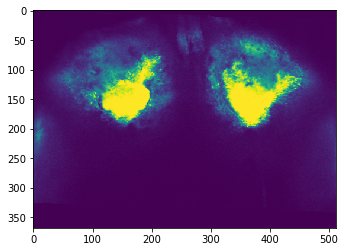

In [52]:
plt.imshow(warped_numpy[:,:,65])
plt.show()

In [58]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190228_0.nii'
brain_to_save = np.swapaxes(warped['warpedmovout'].numpy(), 0, 1)
ants.image_write(ants.from_numpy(brain_to_save), save_file)

##### Video makes it look like SyN is not doing anything (maybe even making it worse). WTF is happening? Lets first output first 200 volumes to get sense of motion when looking at a slice.

In [6]:
brain_file = os.path.join(root_path, fly_folders[0], 'functional.nii')

In [7]:
brain_red = load_numpy_brain(brain_file, channel='red')

In [8]:
brain_green = load_numpy_brain(brain_file, channel='green')

In [9]:
mean_red = np.mean(brain_red, axis=-1)

In [10]:
mean_green = np.mean(brain_green, axis=-1)

In [13]:
brain_clipped = brain[:,:,:,:200]

In [12]:
save_file = os.path.join(root_path, fly_folders[0], 'meanbrain_green.nii')
#brain_to_save = np.swapaxes(brain_clipped, 0, 2)
ants.image_write(ants.from_numpy(mean_green), save_file)

##### Ok cool beans. I can see motion, so that will make it easy to see it correction is working. Next, lets output an SyN correction 200 volumes

In [28]:
motCorr_brain_out.shape

(128, 73, 49, 200)

In [16]:
meanbrain = np.mean(brain, axis=-1)

In [17]:
meanbrain.shape

(128, 73, 49)

In [18]:
motCorr_brain = []
transforms = []
meanbrain_ants = ants.from_numpy(meanbrain)
for i in range(200):
    print(i)
    t0 = time()
    brain_vol = ants.from_numpy(brain[:,:,:,i])
    motCorr_vol = ants.registration(meanbrain_ants, brain_vol, type_of_transform='SyN')
    motCorr_brain.append(motCorr_vol['warpedmovout'].numpy())
    transforms.append(motCorr_vol['fwdtransforms'])
    print('Done. Duration: {:.1f}s'.format(time()-t0))

0
Done. Duration: 2.1s
1
Done. Duration: 2.2s
2
Done. Duration: 2.2s
3
Done. Duration: 2.3s
4
Done. Duration: 2.3s
5
Done. Duration: 2.2s
6
Done. Duration: 2.2s
7
Done. Duration: 2.3s
8
Done. Duration: 2.2s
9
Done. Duration: 2.3s
10
Done. Duration: 2.3s
11
Done. Duration: 2.3s
12
Done. Duration: 2.6s
13
Done. Duration: 2.2s
14
Done. Duration: 2.1s
15
Done. Duration: 2.2s
16
Done. Duration: 2.2s
17
Done. Duration: 2.3s
18
Done. Duration: 2.2s
19
Done. Duration: 2.3s
20
Done. Duration: 2.2s
21
Done. Duration: 2.1s
22
Done. Duration: 2.2s
23
Done. Duration: 2.4s
24
Done. Duration: 2.2s
25
Done. Duration: 2.3s
26
Done. Duration: 2.4s
27
Done. Duration: 2.3s
28
Done. Duration: 2.2s
29
Done. Duration: 2.3s
30
Done. Duration: 2.3s
31
Done. Duration: 2.3s
32
Done. Duration: 2.4s
33
Done. Duration: 2.3s
34
Done. Duration: 2.4s
35
Done. Duration: 2.3s
36
Done. Duration: 2.2s
37
Done. Duration: 2.3s
38
Done. Duration: 2.2s
39
Done. Duration: 2.6s
40
Done. Duration: 2.2s
41
Done. Duration: 2.1s
42

##### Ok, motion correction is very obvious!!! Excellent. Lets try to make the surface plots again - maybe I made a dumb mistake last time. Hopefully this works - if not we can dig into it a bit more.

In [29]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_15/surface_movie_SyN'

In [30]:
if not os.path.exists(directory):
    os.makedirs(directory)

In [31]:
#######################
### DUAL PLOT MOVIE ###
#######################

t0 = time()
surface_mean = make_brain_surface(meanbrain, thresh=None, sigma=1, scale=4)
for i in range(200):
    surface_vol = make_brain_surface(motCorr_brain_out[:,:,:,i], thresh=None, sigma=1, scale=4)
    surfaces = [surface_mean, surface_vol]
    plot_dual_surfaces(surfaces, save=True, frame=i, folder=directory)
print(time()-t0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
557.5782473087311


##### Still looks like shit. lets see what thresh is doing

In [95]:
brain_thresh_all = []
thresh = 500
for i in range(200):
    brain_test = scipy.ndimage.filters.gaussian_filter(motCorr_brain_out[:,:,:,i], sigma=1)
    #thresh = skimage.filters.threshold_triangle(brain_test, nbins=256)
    brain_thresh = np.copy(brain_test)
    brain_thresh[brain_thresh < thresh] = np.nan
    brain_thresh_all.append(brain_thresh)
    print(i, thresh)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500
10 500
11 500
12 500
13 500
14 500
15 500
16 500
17 500
18 500
19 500
20 500
21 500
22 500
23 500
24 500
25 500
26 500
27 500
28 500
29 500
30 500
31 500
32 500
33 500
34 500
35 500
36 500
37 500
38 500
39 500
40 500
41 500
42 500
43 500
44 500
45 500
46 500
47 500
48 500
49 500
50 500
51 500
52 500
53 500
54 500
55 500
56 500
57 500
58 500
59 500
60 500
61 500
62 500
63 500
64 500
65 500
66 500
67 500
68 500
69 500
70 500
71 500
72 500
73 500
74 500
75 500
76 500
77 500
78 500
79 500
80 500
81 500
82 500
83 500
84 500
85 500
86 500
87 500
88 500
89 500
90 500
91 500
92 500
93 500
94 500
95 500
96 500
97 500
98 500
99 500
100 500
101 500
102 500
103 500
104 500
105 500
106 500
107 500
108 500
109 500
110 500
111 500
112 500
113 500
114 500
115 500
116 500
117 500
118 500
119 500
120 500
121 500
122 500
123 500
124 500
125 500
126 500
127 500
128 500
129 500
130 500
131 500
132 500
133 500
134 500
135 500
136 500
137 500
138 50

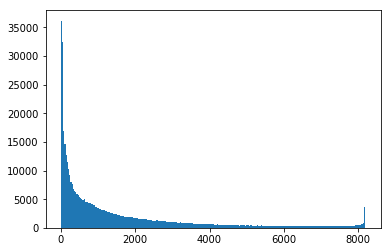

In [93]:
plt.hist(np.ndarray.flatten(motCorr_brain_out[:,:,:,0]),bins=256);
plt.show()

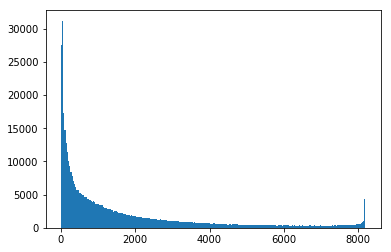

In [94]:
plt.hist(np.ndarray.flatten(motCorr_brain_out[:,:,:,162]),bins=256);
plt.show()

In [96]:
brain_thresh_all = np.asarray(brain_thresh_all)

In [97]:
brain_thresh_all.shape

(200, 128, 73, 49)

In [98]:
brain_thresh_all = np.moveaxis(brain_thresh_all,0,-1)

In [99]:
brain_thresh_all.shape

(128, 73, 49, 200)

In [100]:
save_file = os.path.join(root_path, fly_folders[0], 'thresh_500.nii')
#brain_to_save = np.swapaxes(brain_clipped, 0, 2)
ants.image_write(ants.from_numpy(brain_thresh_all), save_file)

In [40]:
brain_test = scipy.ndimage.filters.gaussian_filter(brain[:,:,:,0], sigma=1)

In [41]:
thresh = skimage.filters.threshold_triangle(brain_test, nbins=256)

In [52]:
brain_thresh = np.copy(brain_test)

In [53]:
brain_thresh[brain_thresh < thresh] = 0

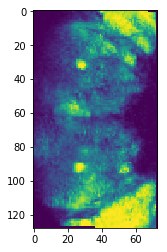

In [80]:
plt.imshow(motCorr_brain_out[:,:,20,0])
plt.show()

In [72]:
brain_thresh_small = rescale_brain(brain_thresh, 4)

In [73]:
x,y,z,filled,facecolors = plot_cube(brain_thresh_small)

In [76]:
brain_thresh_small.shape

(32, 18, 12)

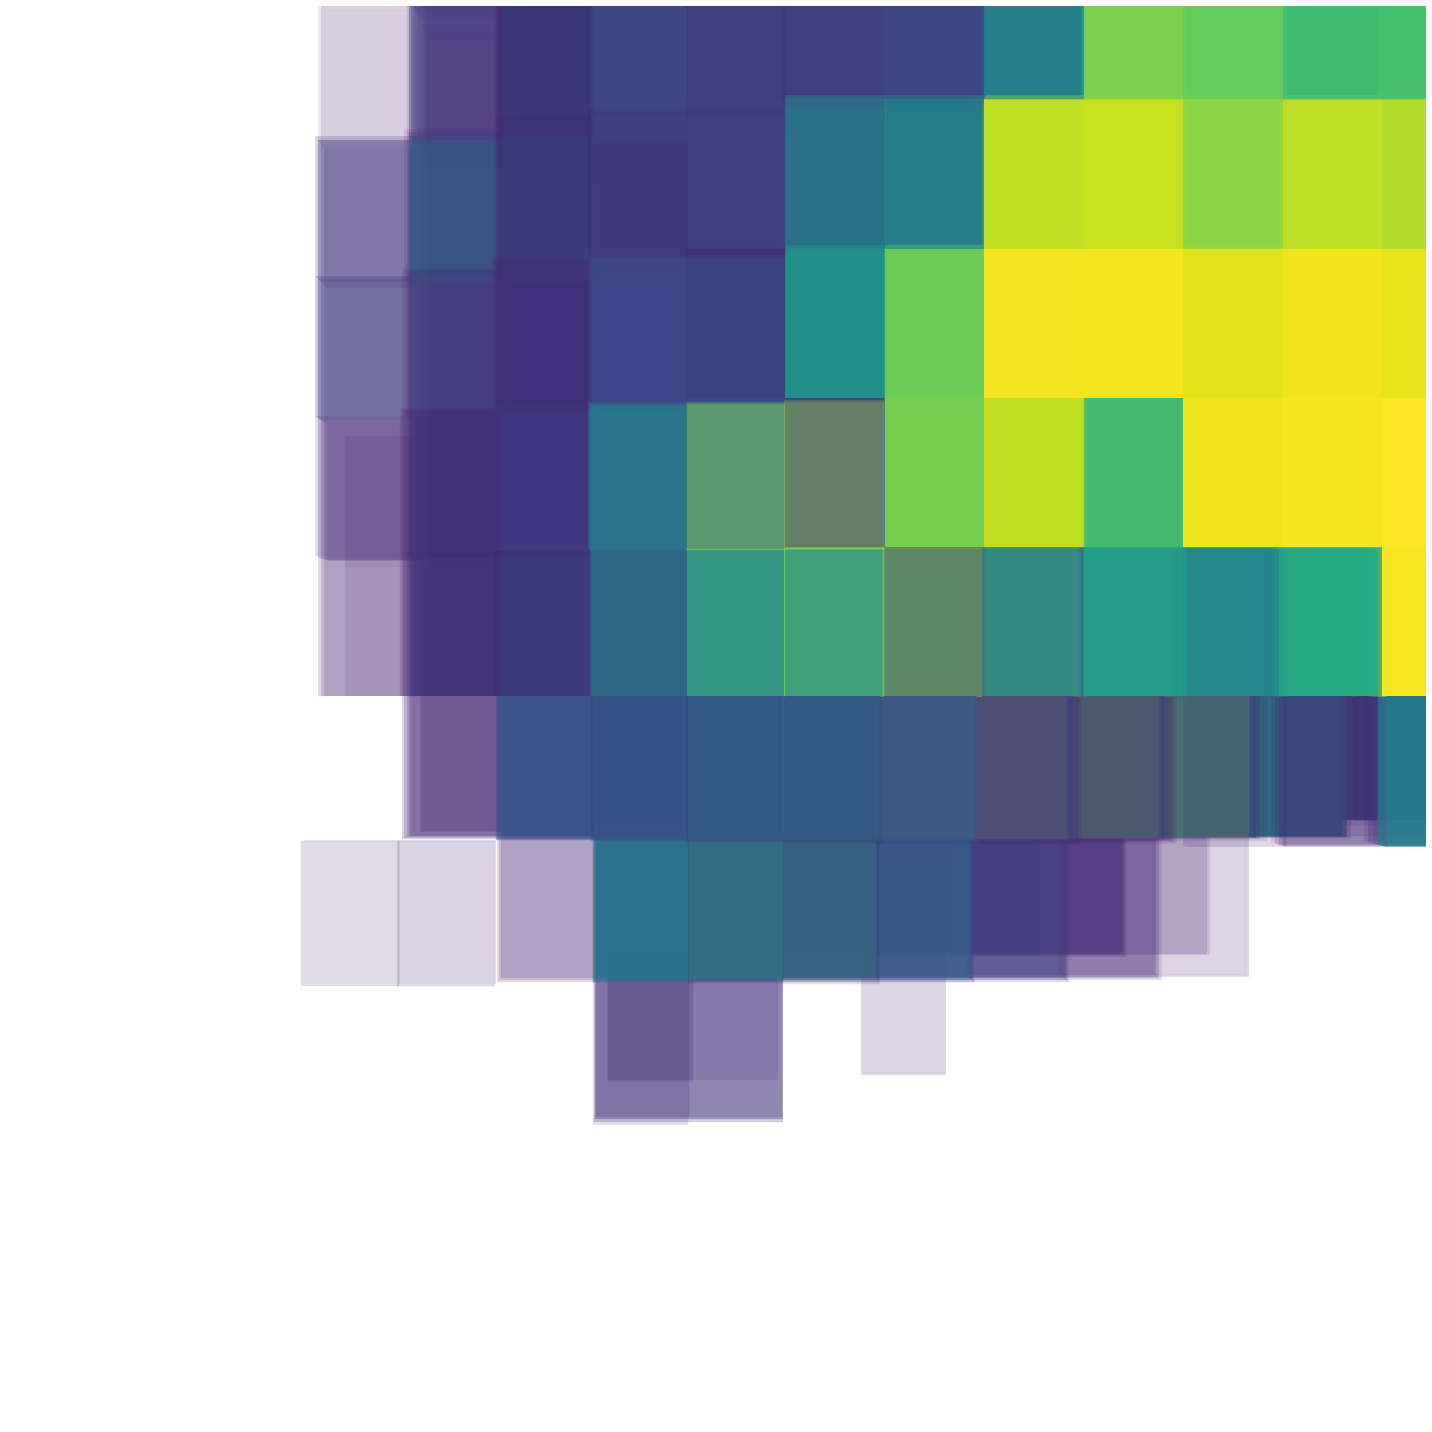

In [77]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')

ax.voxels(x, y, z, filled, facecolors=facecolors)
ax.view_init(0, 0)

set_axes_equal(ax) 
ax.set_xlim(0, 32)
ax.set_ylim(0, 18)
ax.set_zlim(0, 12)
ax._axis3don = False
plt.tight_layout()

plt.show()

In [70]:
brain_thresh.shape

(128, 73, 49)

##### Lets make a movie of the first 10 volumes

In [18]:
t0 = time()
surface_mean = make_brain_surface(meanbrain, thresh=None, sigma=1, scale=2)
movie_folder = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/movie_moving'
for i in range(200):
    surface_vol = make_brain_surface(brain[:,:,:,i], thresh=None, sigma=1, scale=2)
    surfaces = [surface_mean, surface_vol]
    plot_surfaces(surfaces, elev=0, azim=90, save=True, frame=i, folder=movie_folder)
print(time()-t0)

0
1
2
3
4


/home/users/brezovec/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
1036.2442424297333


##### Nice! Next, lets align the first 100 frames

In [19]:
#load affine transform file
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_15/motcorr_params.npy'
motcorr_params = np.load(file)
for i in range(200):
    ants.apply_transform(motcorr_params[i,:])


In [48]:
brain_out = []
for i in range(200):
    print(i)
    brain_vol = ants.from_numpy(brain[:,:,:,i])
    brain_out.append(ants.apply_transforms(moving=brain_vol, fixed=meanbrain_ants, transformlist=transforms[i][1]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [54]:
brain_out = []
for i in range(200):
    print(i)
    brain_vol = ants.from_numpy(brain[:,:,:,i])
    brain_out.append(ants.apply_transforms(moving=brain_vol, fixed=meanbrain_ants, transformlist=transforms[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [57]:
help(ants.apply_transforms)

Help on function apply_transforms in module ants.registration.apply_transforms:

apply_transforms(fixed, moving, transformlist, interpolator='linear', imagetype=0, whichtoinvert=None, compose=None, verbose=False, **kwargs)
    Apply a transform list to map an image from one domain to another.
    In image registration, one computes mappings between (usually) pairs
    of images. These transforms are often a sequence of increasingly
    complex maps, e.g. from translation, to rigid, to affine to deformation.
    The list of such transforms is passed to this function to interpolate one
    image domain into the next image domain, as below. The order matters
    strongly and the user is advised to familiarize with the standards
    established in examples.
    
    ANTsR function: `antsApplyTransforms`
    
    Arguments
    ---------
    fixed : ANTsImage
        fixed image defining domain into which the moving image is transformed.
    
    moving : AntsImage
        moving image to be

In [59]:
transforms[0]

['/tmp/tmp46s6s1x61Warp.nii.gz', '/tmp/tmp46s6s1x60GenericAffine.mat']

In [87]:
surface_mean = make_brain_surface(meanbrain, thresh=None, sigma=1, scale=2)

In [150]:
surface_vol = make_brain_surface(brain[:,:,:,3000], thresh=None, sigma=1, scale=2)

In [151]:
surfaces = [surface_mean, surface_vol]

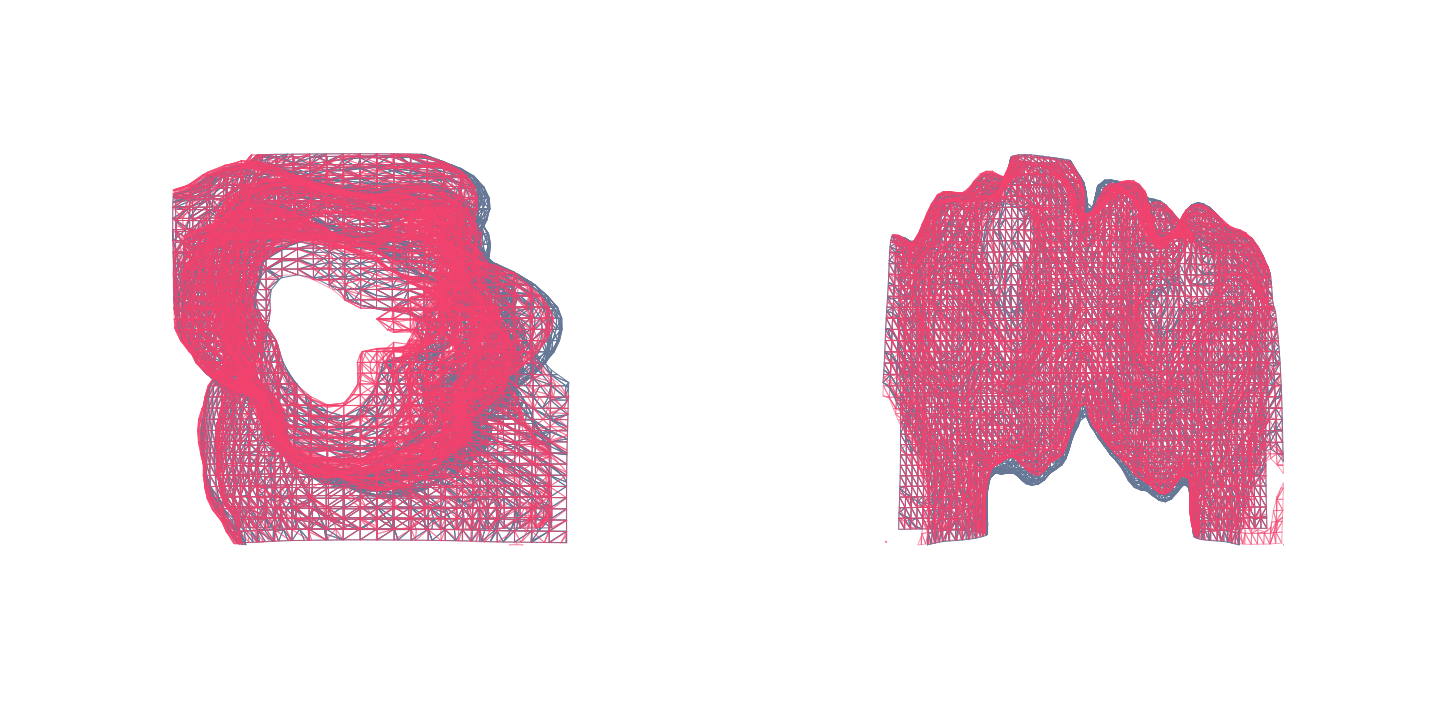

In [197]:
plot_dual_surfaces(surfaces)